In [43]:
# Import libraries
import zipfile
import os
from pathlib import Path
import random
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import datetime
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Replace 'your_file.zip'
with zipfile.ZipFile('drive/MyDrive/Rock-Paper-Scissors.zip', 'r') as zip_ref:
  zip_ref.extractall()  # Extract all files from the ZIP
  zip_ref.close()


In [ ]:
# How many images in each folder?


# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("Rock-Paper-Scissors"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'Rock-Paper-Scissors'.
There are 3 directories and 0 images in 'Rock-Paper-Scissors/validation'.
There are 0 directories and 11 images in 'Rock-Paper-Scissors/validation/paper'.
There are 0 directories and 11 images in 'Rock-Paper-Scissors/validation/rock'.
There are 0 directories and 11 images in 'Rock-Paper-Scissors/validation/scissors'.
There are 3 directories and 0 images in 'Rock-Paper-Scissors/test'.
There are 0 directories and 124 images in 'Rock-Paper-Scissors/test/paper'.
There are 0 directories and 124 images in 'Rock-Paper-Scissors/test/rock'.
There are 0 directories and 124 images in 'Rock-Paper-Scissors/test/scissors'.
There are 3 directories and 0 images in 'Rock-Paper-Scissors/train'.
There are 0 directories and 840 images in 'Rock-Paper-Scissors/train/paper'.
There are 0 directories and 840 images in 'Rock-Paper-Scissors/train/rock'.
There are 0 directories and 840 images in 'Rock-Paper-Scissors/train/scissors'.


In [3]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32

train_dir = "Rock-Paper-Scissors/train/"
test_dir = "Rock-Paper-Scissors/test/"
validation_dir = "Rock-Paper-Scissors/validation/"

train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
validation_datagen = ImageDataGenerator(rescale=1/255.)

print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                                   batch_size=BATCH_SIZE,
                                                                   class_mode='categorical',
                                                                   shuffle=True)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(IMG_HEIGHT,IMG_WIDTH),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               shuffle=True)

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=(IMG_HEIGHT,IMG_WIDTH),
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical'
                                            )

print("Validation images:")
validation_data = validation_datagen.flow_from_directory(validation_dir,
                                            target_size=(IMG_HEIGHT,IMG_WIDTH),
                                            class_mode='categorical',
                                            shuffle=False
                                            )


Augmented training images:
Found 2520 images belonging to 3 classes.
Training images:
Found 2520 images belonging to 3 classes.
Testing images:
Found 372 images belonging to 3 classes.
Validation images:
Found 33 images belonging to 3 classes.


In [ ]:
train_data_augmented.class_indices




{'paper': 0, 'rock': 1, 'scissors': 2}

In [ ]:
train_data.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [ ]:
test_data.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [ ]:
validation_data.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [9]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)

data_dir = pathlib.Path("Rock-Paper-Scissors/validation/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['paper' 'rock' 'scissors']


In [26]:
images, labels = train_data[0]  # Get the first batch of data
augmented_images, augmented_labels = train_data_augmented[0]  # Get the first batch of augmented data

In [ ]:
# Show original image and augmented image
random_number = random.randint(0, 31) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [ ]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
vgg_url = "https://tfhub.dev/google/imagenet/vgg16/feature_vector/4"

# Load the VGG16 model without the top (fully connected) layers
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))



In [ ]:
x = vgg_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=vgg_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in vgg_model.layers:
    layer.trainable = False





In [ ]:
class LearningRateFinder(tf.keras.callbacks.Callback):
    def __init__(self, min_lr=1e-8, max_lr=2, momentum=0.9, logscale=True, num_iterations=100):
        super(LearningRateFinder, self).__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.momentum = momentum
        self.logscale = logscale
        self.num_iterations = num_iterations

    def on_train_begin(self, logs=None):
        self.learning_rates = []
        self.losses = []
        self.best_loss = np.inf
        self.avg_loss = 0
        self.batch_num = 0
        self.beta = 0.98

    def on_batch_end(self, batch, logs=None):
        lr = self.get_lr()
        self.batch_num += 1
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * logs['loss']
        smoothed_loss = self.avg_loss / (1 - self.beta**self.batch_num)

        self.learning_rates.append(lr)
        self.losses.append(smoothed_loss)

        if smoothed_loss < self.best_loss or self.batch_num==1:
            self.best_loss = smoothed_loss
        if smoothed_loss > 4 * self.best_loss or lr > self.max_lr:
            self.model.stop_training = True

    def get_lr(self):
        if self.logscale:
            return self.min_lr * (self.max_lr/self.min_lr)**(self.batch_num/self.num_iterations)
        return self.min_lr + (self.max_lr-self.min_lr)*(self.batch_num/self.num_iterations)

    def plot_lr(self):
        plt.plot(self.learning_rates, self.losses)
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [ ]:
# model = create_model(efficientnet_url,num_classes=train_data.num_classes)

lr_finder = LearningRateFinder(min_lr=1e-8, max_lr=2, num_iterations=100)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# steps_per_epoch = len(train_data) + len(train_data_augmented) #this is mandatory, otherwise it will keep looping


In [ ]:
history = model.fit(
    x=train_data_augmented,
    epochs=1,  # Run for only one epoch
    validation_data=test_data,
    callbacks=[lr_finder],
    verbose=0
)

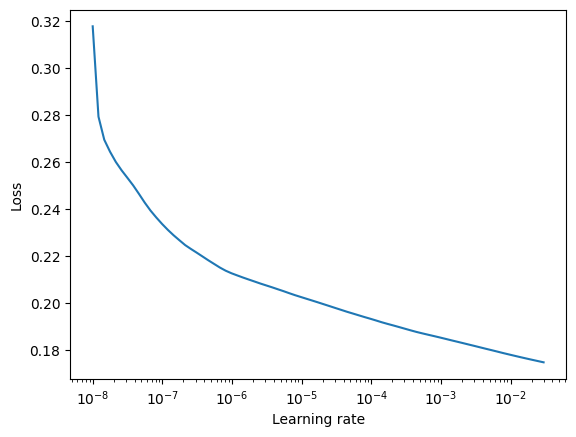

In [ ]:
lr_finder.plot_lr()

In [ ]:
history = model.fit(
        x=train_data_augmented,
        validation_data=test_data,
        batch_size=32,
        epochs=10,
        verbose=1
    )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 49s 581ms/step - accuracy: 0.9924 - loss: 0.0361 - val_accuracy: 0.9785 - val_loss: 0.0595
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 82s 576ms/step - accuracy: 0.9936 - loss: 0.0258 - val_accuracy: 1.0000 - val_loss: 0.0325
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 82s 571ms/step - accuracy: 0.9947 - loss: 0.0243 - val_accuracy: 0.9946 - val_loss: 0.0388
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 81s 576ms/step - accuracy: 0.9894 - loss: 0.0313 - val_accuracy: 0.9731 - val_loss: 0.0716
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 82s 579ms/step - accuracy: 0.9970 - loss: 0.0166 - val_accuracy: 1.0000 - val_loss: 0.0216
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 83s 577ms/step - accuracy: 0.9893 - loss: 0.0292 - val_accuracy: 0.9731 - val_loss: 0.0482
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 81s 571ms/step - accuracy: 0.9917 - loss: 0.0259 - val_accuracy: 0.9651 - val_loss: 0.1134
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 49s 583ms/step - accuracy: 0.9949 - loss: 0.0180 - val_accuracy: 0.975

In [ ]:
# Save a model
model.save("train1vgg_augmented_model.keras")

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

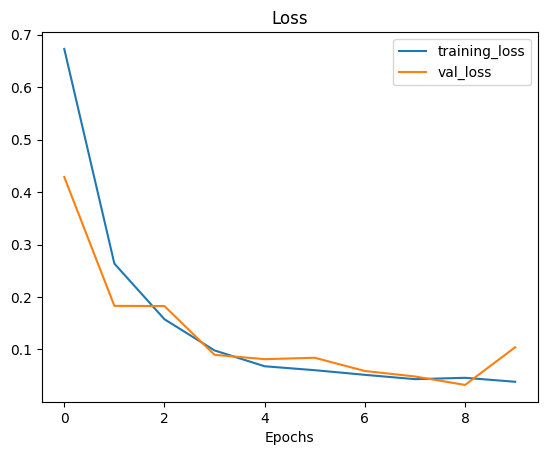

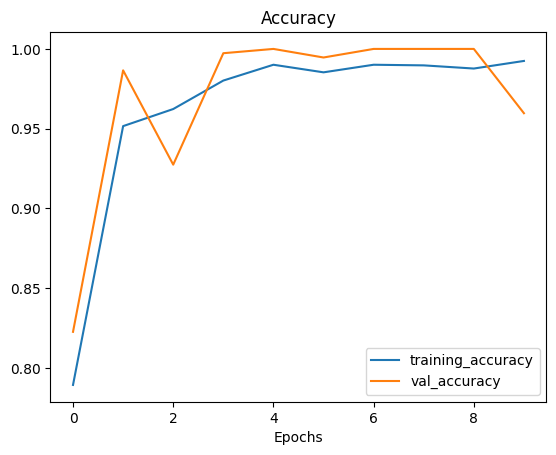

In [ ]:
# Check out the loss curves of model
plot_loss_curves(history)

In [7]:
def load_and_prep_image(filename, img_shape=256, scale=True):

  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  img = img[:,:,:3]
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
# Load in a model and evaluate it
loaded_model1 = tf.keras.models.load_model("train1vgg_noaugmen_model")
loaded_model1.evaluate(validation_data)

In [4]:
# Load in a model and evaluate it
loaded_model2 = tf.keras.models.load_model("drive/MyDrive/train1vgg_augmented_model.keras")

# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = loaded_model2.evaluate(validation_data)
loaded_loss, loaded_accuracy


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.9081 - loss: 0.2362


(0.23375894129276276, 0.9090909361839294)

In [13]:
# Get custom food images filepaths
custom_images = ["Rock-Paper-Scissors/validation/rock/" + img_path for img_path in os.listdir("Rock-Paper-Scissors/validation/rock/")]
custom_images



['Rock-Paper-Scissors/validation/rock/rock-hires1.png',
 'Rock-Paper-Scissors/validation/rock/rock5.png',
 'Rock-Paper-Scissors/validation/rock/rock7.png',
 'Rock-Paper-Scissors/validation/rock/rock2.png',
 'Rock-Paper-Scissors/validation/rock/rock4.png',
 'Rock-Paper-Scissors/validation/rock/rock1.png',
 'Rock-Paper-Scissors/validation/rock/rock3.png',
 'Rock-Paper-Scissors/validation/rock/rock8.png',
 'Rock-Paper-Scissors/validation/rock/rock9.png',
 'Rock-Paper-Scissors/validation/rock/rock6.png',
 'Rock-Paper-Scissors/validation/rock/rock-hires2.png']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


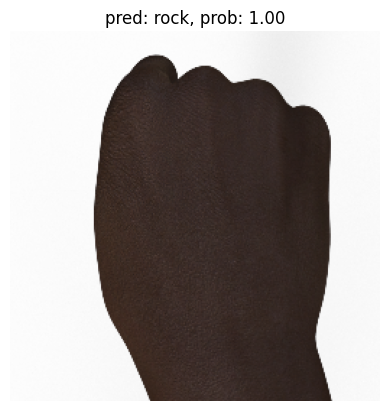

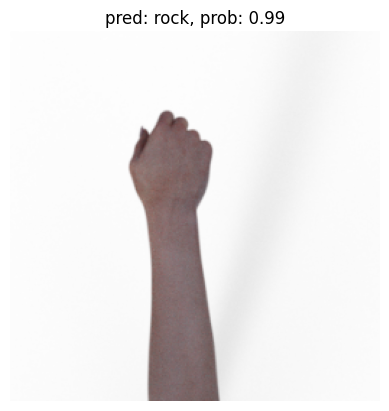

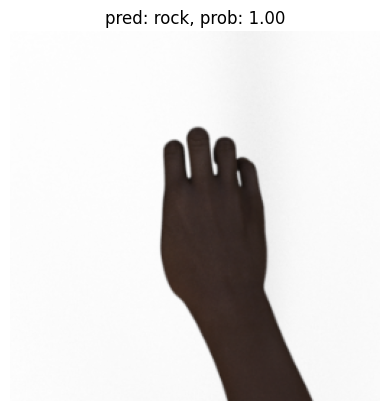

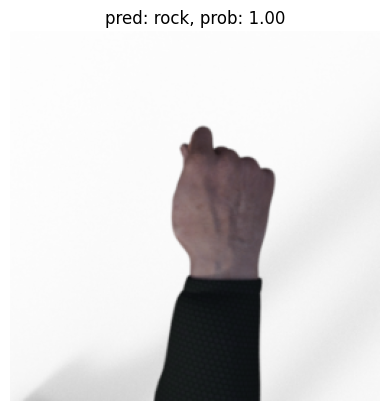

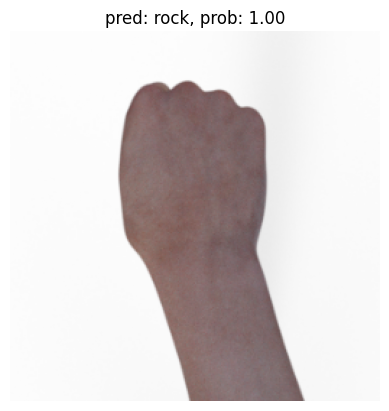

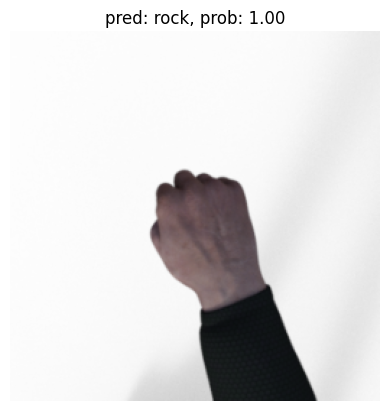

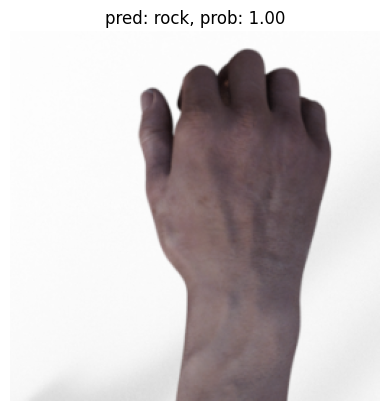

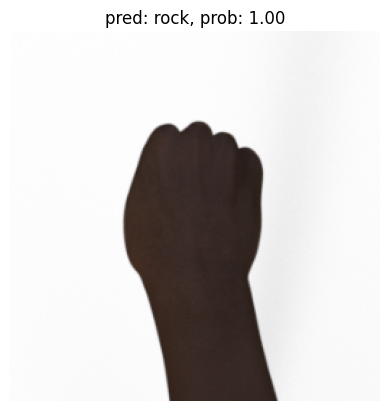

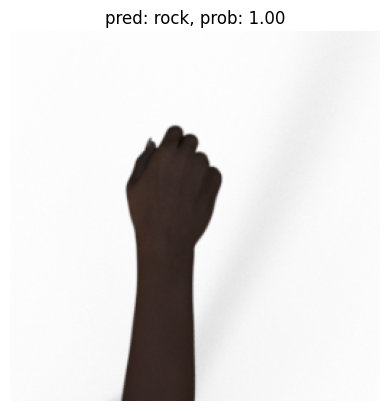

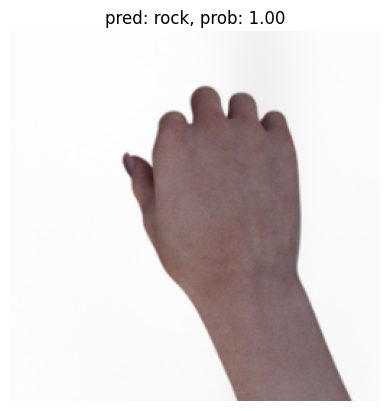

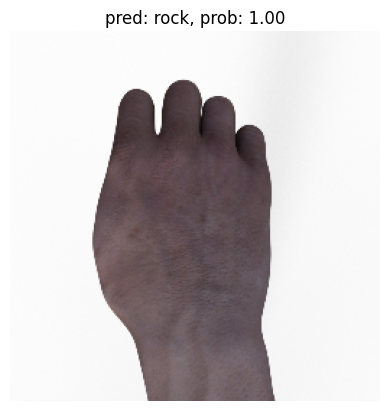

In [14]:
# Make predictions on custom food images
for img in custom_images:
  img = load_and_prep_image(img, scale=True) # load in target image and turn it into tensor
  pred_prob = loaded_model2.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

In [123]:
# Make predictions with model
pred_probs = loaded_model2.predict(validation_data, verbose=1) # set verbosity to see how long it will take

pred_classes = pred_probs.argmax(axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


In [124]:
print(type(labels))
pred_classes


<class 'numpy.ndarray'>


array([0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [120]:
y_labels = []
validation_data.reset()  # Reset the iterator

for i in range(len(validation_data)):
    batch = validation_data[i]  # Use i instead of 0 to get different batches
    images, labels = batch
    y_labels.extend(np.argmax(labels, axis=1))

y_labels = np.array(y_labels)

Number of validation samples: 33


In [121]:
y_labels  # Check the first 10 labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [122]:
print("Shape of pred_classes:", pred_classes.shape)
print("Shape of y_labels:", y_labels.shape)

Shape of pred_classes: (32,)
Shape of y_labels: (33,)


In [125]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.9090909090909091

In [126]:
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")


Close? True | Difference: 2.7093020382729094e-08


In [127]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [128]:
class_names = list(validation_data.class_indices.keys())
class_names[:10]

['paper', 'rock', 'scissors']

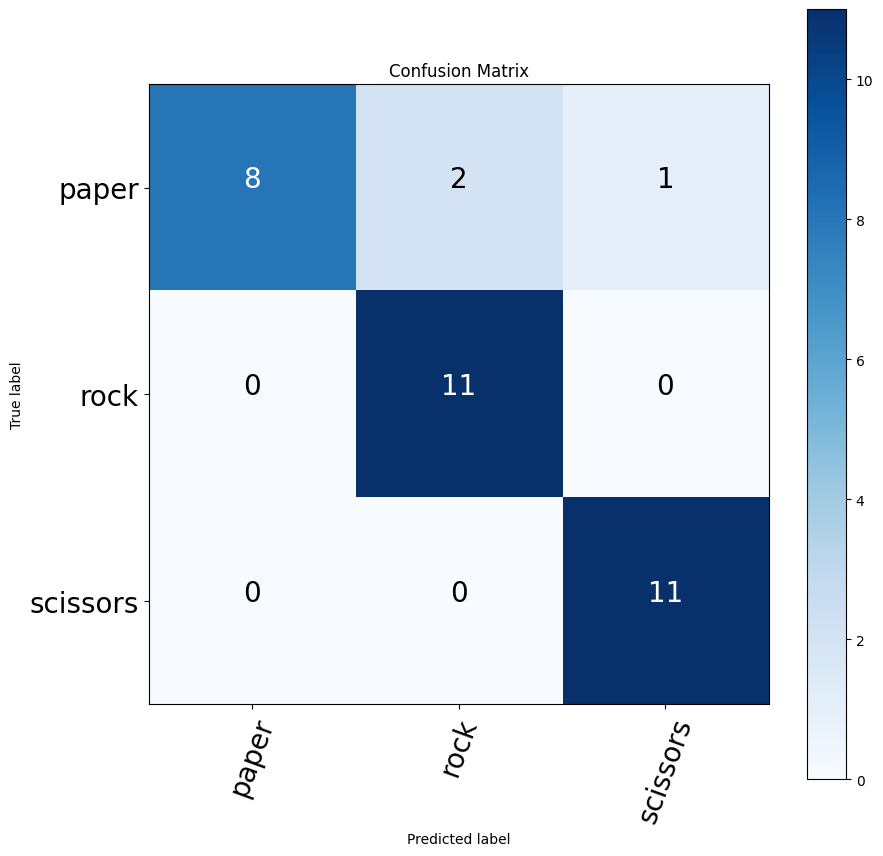

In [129]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(10, 10),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [130]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.85      1.00      0.92        11
           2       0.92      1.00      0.96        11

    accuracy                           0.91        33
   macro avg       0.92      0.91      0.91        33
weighted avg       0.92      0.91      0.91        33



In [131]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 1.0,
  'recall': 0.7272727272727273,
  'f1-score': 0.8421052631578948,
  'support': 11.0},
 '1': {'precision': 0.8461538461538461,
  'recall': 1.0,
  'f1-score': 0.9166666666666666,
  'support': 11.0},
 '2': {'precision': 0.9166666666666666,
  'recall': 1.0,
  'f1-score': 0.9565217391304348,
  'support': 11.0},
 'accuracy': 0.9090909090909091,
 'macro avg': {'precision': 0.9209401709401709,
  'recall': 0.9090909090909092,
  'f1-score': 0.9050978896516654,
  'support': 33.0},
 'weighted avg': {'precision': 0.9209401709401709,
  'recall': 0.9090909090909091,
  'f1-score': 0.9050978896516655,
  'support': 33.0}}

In [132]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'paper': 0.8421052631578948,
 'rock': 0.9166666666666666,
 'scissors': 0.9565217391304348}

In [133]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

,class_name,f1-score
2,scissors,0.956522
1,rock,0.916667
0,paper,0.842105


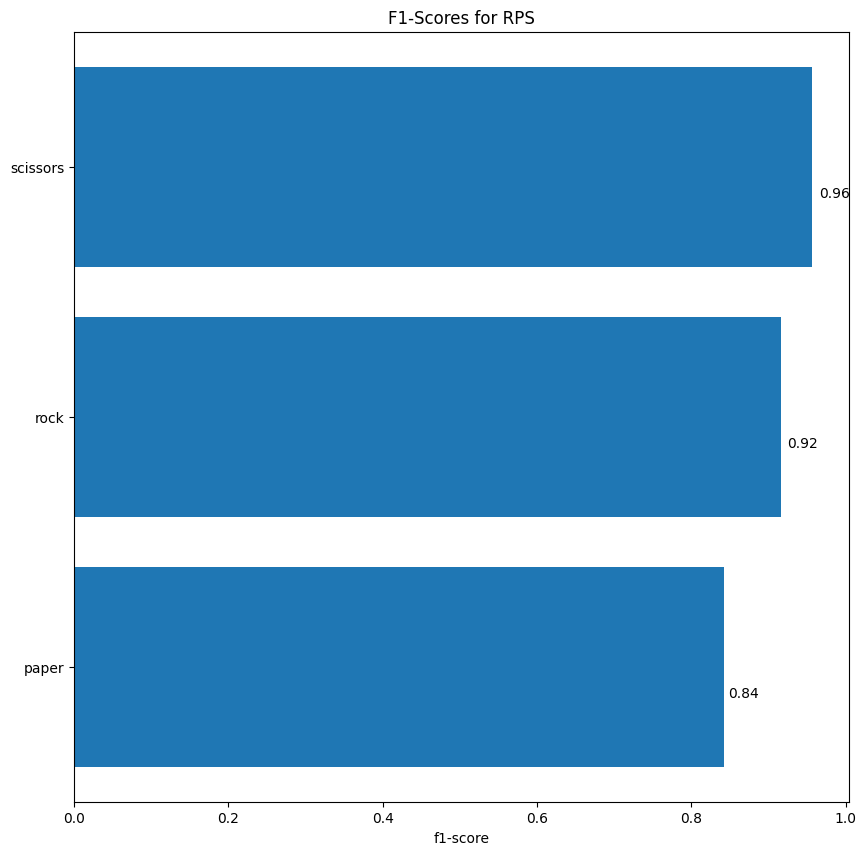

In [134]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for RPS")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)